In [10]:
from openai import Client
from os import getenv

client = Client(
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

response = client.chat.completions.create(
    # model="deepseek/deepseek-r1",
    # model="anthropic/claude-3.7-sonnet:thinking",
    # model="anthropic/claude-sonnet-4",
    # model="google/gemini-2.5-flash-preview-05-20:thinking",
    # model="openai/o4-mini",
    model="moonshotai/kimi-k2.5",
    # model="anthropic/claude-opus-4.6",
    messages=[
        {"role": "user", "content": "What is the capital of France?"}
    ],
    extra_body={"include_reasoning": True, "reasoning_effort": "low"}
)

In [11]:
print("===Reasoning===")
print(response.choices[0].message.reasoning)
print("===Answer===")
print(response.choices[0].message.content)


===Reasoning===
The user is asking a very straightforward question: "What is the capital of France?" This is a basic factual question that requires a simple, direct answer. The capital of France is Paris. I should provide this answer clearly and concisely. There's no need for complex reasoning or additional context unless it adds value, but for such a simple question, a straightforward answer is best.

I should verify: Yes, Paris is indeed the capital of France. It has been the capital for many centuries and is the political, cultural, and economic center of the country.

The answer should be: Paris.
===Answer===
The capital of France is **Paris**.


In [12]:
response.model_dump()

{'id': 'gen-1770827692-7AwyoGrSFFixfJHOIYaZ',
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'logprobs': None,
   'message': {'content': 'The capital of France is **Paris**.',
    'refusal': None,
    'role': 'assistant',
    'annotations': None,
    'audio': None,
    'function_call': None,
    'tool_calls': None,
    'reasoning': 'The user is asking a very straightforward question: "What is the capital of France?" This is a basic factual question that requires a simple, direct answer. The capital of France is Paris. I should provide this answer clearly and concisely. There\'s no need for complex reasoning or additional context unless it adds value, but for such a simple question, a straightforward answer is best.\n\nI should verify: Yes, Paris is indeed the capital of France. It has been the capital for many centuries and is the political, cultural, and economic center of the country.\n\nThe answer should be: Paris.',
    'reasoning_details': [{'format': 'unknown',
      'i

In [15]:
import pandas as pd
from openai import Client
from os import getenv
from tqdm import tqdm

client = Client(
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

def run_question_across_models(question: str, answer: str) -> pd.DataFrame:
    models = [
        "openai/gpt-3.5-turbo",
        "openai/o4-mini",
        "openai/o4-mini-high",
        "openai/o3",
        "anthropic/claude-3.7-sonnet:thinking",
        "anthropic/claude-sonnet-4",
        "moonshotai/kimi-k2.5",
        "anthropic/claude-opus-4.6"
    ]
    
    results = []
    
    for model in tqdm(models):
        for reasoning_effort in ["low", "medium", "high", None]:
            try:
                body = {"include_reasoning": True}
                if reasoning_effort is not None:
                    body['reasoning_effort'] = reasoning_effort
                response = client.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": question}],
                    extra_body=body
                )
                reasoning = getattr(response.choices[0].message, "reasoning", None)
                content = response.choices[0].message.content
            except Exception as e:
                reasoning = f"Error: {e}"
                content = "N/A"
            
            results.append({
                "model": model,
                "reasoning": reasoning,
                "answer": content,
                "reasoning_effort": reasoning_effort,
                "correct": answer in content
            })
    
    return pd.DataFrame(results)


In [16]:
results_df = run_question_across_models(
    question="which is bigger, pi * 28.5 or 89? Output the final answer in a box so either [pi * 28.5] or [89]",
    answer="[pi * 28.5]"
)

100%|████████████████████████████████████████████████████████████| 10/10 [04:34<00:00, 27.45s/it]


In [17]:
# confirming 3.5 has no reasoning
results_df[results_df['model'] == 'openai/gpt-3.5-turbo']

,model,reasoning,answer,reasoning_effort,correct
0,openai/gpt-3.5-turbo,None,[pi * 28.5],low,True
1,openai/gpt-3.5-turbo,None,[pi * 28.5],medium,True
2,openai/gpt-3.5-turbo,None,[89],high,False
3,openai/gpt-3.5-turbo,None,[pi * 28.5],None,True


In [18]:
# sonnet 4 can turn off thinking entirely on command
results_df[results_df['model'] == "anthropic/claude-sonnet-4"]

,model,reasoning,answer,reasoning_effort,correct
20,anthropic/claude-sonnet-4,"I need to compare pi * 28.5 and 89.\n\nFirst, ...",I need to calculate π × 28.5 and compare it to...,low,True
21,anthropic/claude-sonnet-4,"I need to compare π × 28.5 and 89.\n\nFirst, l...",I need to calculate π × 28.5 and compare it to...,medium,True
22,anthropic/claude-sonnet-4,"I need to compare π * 28.5 with 89.\n\nFirst, ...",I need to calculate π × 28.5 and compare it to...,high,True
23,anthropic/claude-sonnet-4,None,"I need to compare π × 28.5 with 89.\n\nFirst, ...",None,True


In [19]:
# o3 can't turn off thinking and yet didn't produce it sometimes
results_df[results_df['model'] == "openai/o3"]

,model,reasoning,answer,reasoning_effort,correct
12,openai/o3,**Calculating pi times 28.5**\n\nI need to com...,[pi * 28.5],low,True
13,openai/o3,**Comparing Values**\n\nI'm tasked with compar...,[pi * 28.5],medium,True
14,openai/o3,None,[pi * 28.5],high,True
15,openai/o3,None,[pi * 28.5],None,True


In [35]:
# Anthropic Opus 4.6 got the answer right but didn't quite follow my instruction so our script didn't pick it up
print(results_df[results_df['model'] == "anthropic/claude-opus-4.6"].iloc[1]['answer'])



## Comparing π × 28.5 and 89

**π × 28.5** = 3.14159265… × 28.5 ≈ **89.536**

Since 89.536 > 89:

$\boxed{\pi \times 28.5}$


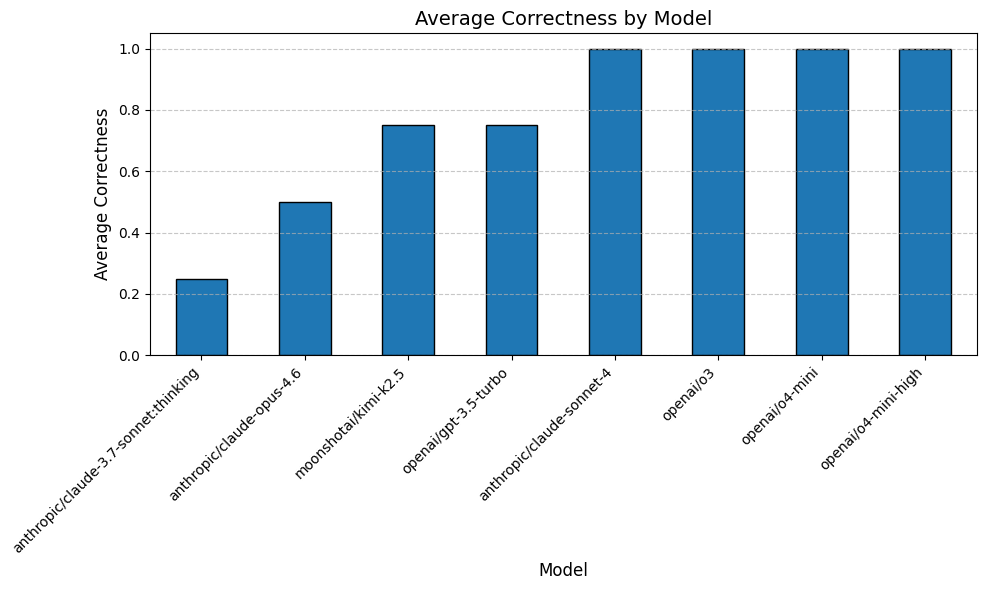

In [29]:
import matplotlib.pyplot as plt

# Group by model and calculate mean correctness
model_means = results_df.groupby('model')['correct'].mean().sort_values()

# Plot
plt.figure(figsize=(10, 6))
model_means.plot(kind='bar', edgecolor='black')

# Title and labels
plt.title('Average Correctness by Model', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Average Correctness', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


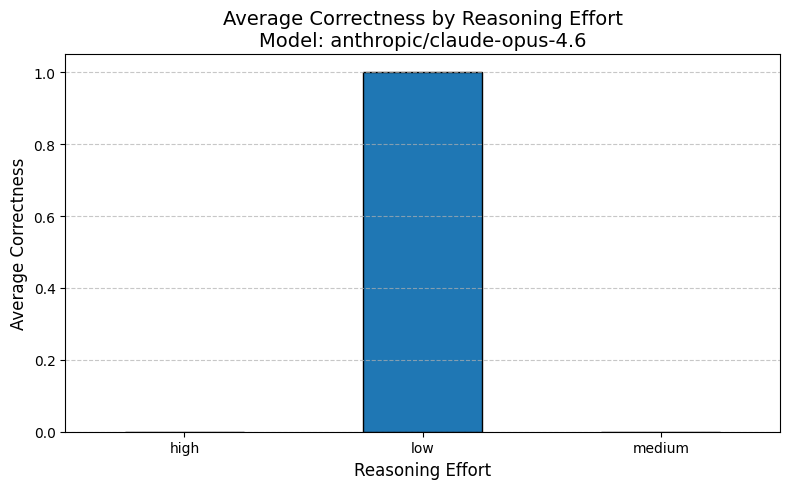

In [30]:
import matplotlib.pyplot as plt

selected_model = "anthropic/claude-opus-4.6"

# Filter to that model
filtered_df = results_df[results_df["model"] == selected_model]

# Group by reasoning_effort and compute mean correctness
effort_means = (
    filtered_df
    .groupby("reasoning_effort")["correct"]
    .mean()
    .sort_index()
)

# Plot
plt.figure(figsize=(8, 5))
effort_means.plot(kind="bar", edgecolor="black")

plt.title(f"Average Correctness by Reasoning Effort\nModel: {selected_model}", fontsize=14)
plt.xlabel("Reasoning Effort", fontsize=12)
plt.ylabel("Average Correctness", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()


In [40]:
question = "which is bigger, pi * 4532.54 or 14,250?"

def do_req(model, content, include_reasoning=False):
    return client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": content}],
        extra_body={"include_reasoning": include_reasoning, "reasoning_effort": "high"} if include_reasoning else {}
    )

# Step 1: Get reasoning from a reasoning model
content = f"{question} Please think this through, but don't output the answer - only think about the problem, and output 'done' when you have thought about it enough."
reasoning_response = do_req("anthropic/claude-opus-4.6", content, include_reasoning=True)
reasoning = reasoning_response.choices[0].message.reasoning

print("===Reasoning (From Anthropic) ===")
print(reasoning)

# Step 2: Baseline model without reasoning
simple_response = do_req("openai/gpt-3.5-turbo", question)
print("===Simple Answer===")
print(simple_response.choices[0].message.content)

# Step 3: Give it the reasoning and ask again
context_prompt = f"{question}. Here is some context to help you: {reasoning}"
smart_response = do_req("openai/gpt-3.5-turbo", context_prompt)
print("===Answer with Injected Reasoning===")
print(smart_response.choices[0].message.content)


===Reasoning (From Anthropic) ===
Pi * 4532.54 = 3.14159265... * 4532.54

Let me compute this:

3.14159265 * 4532.54

3 * 4532.54 = 13597.62
0.14159265 * 4532.54 ≈ 641.37

So approximately 14238.99

Hmm, that's close to 14,250. Let me be more precise.

0.14159265 * 4532.54:

0.1 * 4532.54 = 453.254
0.04 * 4532.54 = 181.3016


0.001 * 4532.54 = 4.53254
0.0005 * 4532.54 = 2.26627
0.00009265 * 4532.54 = 0.4199

Adding these components together: 453.254 + 181.3016 + 4.53254 + 2.26627 + 0.41994 = 641.774

So the final result is 13597.62 + 641.774 = 14239.394, which means pi * 4532.54 ≈ 14239.39.

Comparing this to 14,250, I can see that 14239.39 is slightly less, so 14,250 is the larger value.
===Simple Answer===
To determine which value is bigger, we can calculate the value of pi * 4532.54:

pi * 4532.54 ≈ 14277.77

Comparing this value to 14,250, we can see that pi * 4532.54 is slightly bigger.
===Answer with Injected Reasoning===
Therefore, 14,250 is bigger than pi * 4532.54.
